In [75]:
# | default_exp model

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TOKENIZERS_PARALLELISM=false


In [92]:
# | export
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    trainers,
    Tokenizer,
)
from tokenizers import ByteLevelBPETokenizer


from typing import Optional
import math
import os
from transformers import GPT2TokenizerFast
from my_transformer.attention import unidirectional_mask, MultiHeadAttention, LayerNormalization

In [88]:
from icecream import ic
from matplotlib import pyplot as plt


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Model

In [99]:
# | export


class FeedForward(nn.Module):
    def __init__(self, model_size: int, mlp_factor: int = 4, dropout: float = 0.1) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(model_size, mlp_factor * model_size),
            nn.RELU(),
            nn.Linear(mlp_factor * model_size, model_size),
            nn.Dropout(dropout),
        )

        def forward(self, x):
            return self.net(x)


class DecoderLayer(nn.Module):
    def __init__(
        self, model_size: int, nb_heads: int = 1, dropout: float = 0.0, bias: bool = True, mlp_factor=4
    ) -> None:
        super().__init__()
        self.layer_norm1 = LayerNormalization(model_size)  # LayerNormalization(model_size)
        self.attn = MultiHeadAttention(d=model_size, h=nb_heads, dropout=dropout, bias=bias)
        self.mlp1 = nn.Linear(model_size, mlp_factor * model_size, bias=bias)
        self.mlp2 = nn.Linear(mlp_factor * model_size, model_size, bias=bias)
        self.activation = nn.RELU()
        self.layer_norm2 = LayerNormalization(model_size)  # LayerNormalization(model_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        b, l, d = x.size()
        norm_x = self.layer_norm1(x)
        attn_x = x + self.attn(norm_x, z=None, mask=mask)[0]

        norm_attn_x = self.layer_norm2(attn_x)
        lin1 = self.activation(self.mlp1(norm_attn_x))
        x = x + self.dropout(self.mlp2(lin1))
        return x

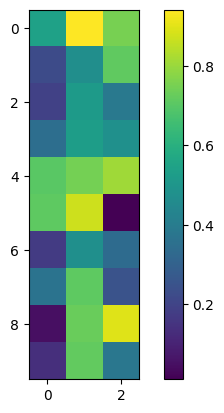

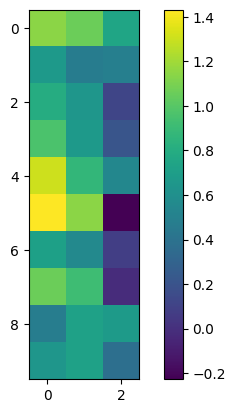

In [100]:
batch_size = 1
seq_len = 10
embedding_dim = 3
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
dl = DecoderLayer(embedding_dim, nb_heads=1, dropout=0.1).to(device)
mask = unidirectional_mask(seq_len=seq_len).to(device)
dlo = dl(x, mask=mask)

plt.imshow(x[0].cpu().detach())
plt.colorbar()
plt.show()

plt.imshow(dlo[0].cpu().detach())
plt.colorbar()
plt.show()

In [95]:
# | export


class DecoderTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int,
        model_size: int,
        nb_heads: int = 1,
        nb_layers: int = 1,
        dropout: float = 0.0,
        bias: bool = True,
    ) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.tok_emb = nn.Embedding(vocab_size, embedding_dim=model_size)
        self.pos_emb = torch.nn.Embedding(max_seq_len, embedding_dim=model_size)

        self.layers = nn.Sequential(
            *[
                DecoderLayer(model_size=model_size, nb_heads=nb_heads, dropout=dropout, bias=bias)
                for i in range(nb_layers)
            ]
        )
        self.layer_norm = LayerNormalization(model_size)
        self.unembedding = nn.Linear(model_size, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, l = x.size()
        emb = self.tok_emb(x)
        x = self.pos_enc(emb)
        mask = unidirectional_mask(seq_len=l).to(x.device)
        for layer in self.layers:
            x = layer(x, mask)
        x = self.layer_norm(x)
        logits = self.unembedding(x)
        return logits

    def generate(self, x: torch.Tensor, max_new_tokens: int):
        for i in range(max_new_tokens):
            # we take at most max_seq_len tokens
            x_block = x[:, -self.max_seq_len :]
            logits = self(x_block)
            # we take the logit for last token, used to predict token.
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            tok_next = torch.multinomial(probs, num_samples=1)
            x = torch.cat((x, tok_next), dim=1)
        return x

In [96]:
# test with karpathy method of gradient check

## Dataset

In [34]:
with open("../dataset/shakespeare.txt") as f:
    text = f.read()


words = text.split(" ")
train_pos = math.ceil(len(words) * 0.8)
train_words = words[:train_pos]
test_words = words[train_pos:]
train_txt = " ".join(train_words[:])
test_txt = " ".join(test_words[:])

## Tokenizer

GPT2 use a byte-level BPE (byte pair encoding) tokenizer. First we train a tokenizer to create a vocabulary and merge file that is required by GPT2.
GPT-2 expects:
- A fixed vocabulary size (e.g., 50,257 tokens).
- Specific special tokens (<|endoftext|>).
- Byte-level encoding to handle all possible text inputs (including non-standard characters).

So GPT2TokenizerFast enrich trained tokenizer

In [ ]:
trained_tokenizer = ByteLevelBPETokenizer()
trained_tokenizer.train_from_iterator([train_txt], vocab_size=1000)
tok_dir = "./shakespare_tok"
os.makedirs(tok_dir, exist_ok=True)
trained_tokenizer.save_model(tok_dir)
tokenizer = GPT2TokenizerFast.from_pretrained(tok_dir)
tokenizer

GPT2TokenizerFast(name_or_path='./shakespare_tok', vocab_size=1000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [61]:
len(tokenizer.encode(train_txt))
tokenizer.encode("hello")

[257, 273, 78]

In [62]:
class BPEDataset(Dataset):
    def __init__(self, text: str, tokenizer: Tokenizer, seq_len: int = 20, device: str = "cpu"):
        self.device = device
        self.seq_len = seq_len
        self.text = text
        self.tokenizer = tokenizer

        self.encoded = torch.tensor(self.tokenizer.encode(self.text), dtype=torch.long, device=device)

    def __len__(self):
        return len(self.encoded) // self.seq_len

    def __getitem__(self, idx):
        data_len = len(self.encoded)
        i = idx * self.seq_len
        if i >= data_len:
            raise ValueError(f"idx {idx} bigger than data length {data_len}")
        x = self.encoded[i : i + self.seq_len]
        y = self.encoded[i + 1 : i + self.seq_len + 1]
        return x, y

In [74]:
train_ds = BPEDataset(train_txt, tokenizer=tokenizer, seq_len=10, device=device)
train_dl = DataLoader(train_ds, batch_size=5)
assert next(iter(train_dl))[0].size() == (5, 10)

(tensor([697, 670, 396, 359, 320, 300], device='mps:0'),
 tensor([670, 396, 359, 320, 300], device='mps:0'))